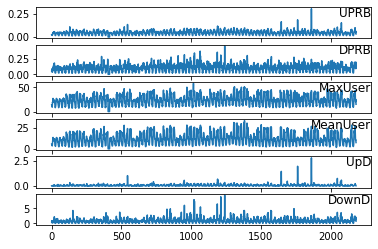

In [2]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('prediction.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('prediction.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.083579   0.117608   0.241379   0.165770   0.227160   0.057341  0.085218
2   0.085218   0.192350   0.206897   0.150283   0.272428   0.097160  0.075713
3   0.075713   0.171686   0.206897   0.137697   0.171193   0.061002  0.059325
4   0.059325   0.109255   0.172414   0.107085   0.060905   0.033850  0.056703
5   0.056703   0.071664   0.155172   0.103577   0.040329   0.015116  0.067519


In [4]:
# split into train and test sets
values = reframed.values
n_train_hours = 30 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(720, 1, 6) (720,) (1463, 1, 6) (1463,)


Train on 720 samples, validate on 1463 samples
Epoch 1/50
 - 1s - loss: 0.0953 - val_loss: 0.0714
Epoch 2/50
 - 0s - loss: 0.0399 - val_loss: 0.0297
Epoch 3/50
 - 0s - loss: 0.0282 - val_loss: 0.0323
Epoch 4/50
 - 0s - loss: 0.0265 - val_loss: 0.0287
Epoch 5/50
 - 0s - loss: 0.0243 - val_loss: 0.0282
Epoch 6/50
 - 0s - loss: 0.0232 - val_loss: 0.0271
Epoch 7/50
 - 0s - loss: 0.0228 - val_loss: 0.0268
Epoch 8/50
 - 0s - loss: 0.0224 - val_loss: 0.0265
Epoch 9/50
 - 0s - loss: 0.0221 - val_loss: 0.0262
Epoch 10/50
 - 0s - loss: 0.0219 - val_loss: 0.0262
Epoch 11/50
 - 0s - loss: 0.0218 - val_loss: 0.0261
Epoch 12/50
 - 0s - loss: 0.0217 - val_loss: 0.0261
Epoch 13/50
 - 0s - loss: 0.0216 - val_loss: 0.0260
Epoch 14/50
 - 0s - loss: 0.0216 - val_loss: 0.0260
Epoch 15/50
 - 0s - loss: 0.0216 - val_loss: 0.0260
Epoch 16/50
 - 0s - loss: 0.0215 - val_loss: 0.0260
Epoch 17/50
 - 0s - loss: 0.0215 - val_loss: 0.0259
Epoch 18/50
 - 0s - loss: 0.0215 - val_loss: 0.0259
Epoch 19/50
 - 0s - loss: 

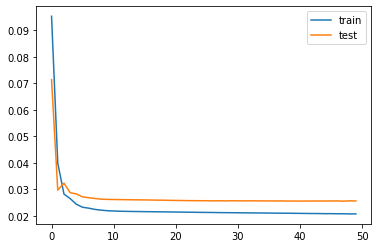

In [5]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense
import matplotlib.pyplot as plt
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')

pyplot.legend()
pyplot.show()

In [5]:
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from math import sqrt
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y,inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.013


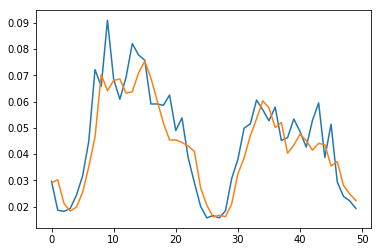

In [6]:
inv_y25 = inv_y[:50]
inv_yhat25 = inv_yhat[:50]

pyplot.plot(inv_y25)
pyplot.plot(inv_yhat25)
pyplot.show()